# Train Localization
This notebook demonstrates train localization with Kalman Filter and Particle Filter. We assume that a train is running on rail between stations. We can measure position of a train on the rail with several sensors and our goal is to estimate its position accurately.

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import pandas as pd
from filters import KalmanFilter, ParticleFilter, TrainSimulator

## Experiment Settings
* Distance between stations: 10km 
* Maximum speed: 300 km/h
* Maximum acceleration/brake: 1.0 m/s2
* Number of sensor: 3
* Measurement  accuracy: 3 m
* Measurement cycle: 100 ms
* Measurement delay: 10 ms
* Probability of outlier: 1%
* 3D state space (position, speed, acceleration)
* R_v update during prediction


## Compare Kalman Filter and Particle Filter

In [2]:
dt = 0.1
sig_w = 0.1
sig_v = 3.0
num_sensor = 3
sensor_delay = 0.01

F = np.array([[1, dt, dt**2/2], [0, 1, dt], [0, 0, 1]])
G = np.array([dt**2/2, dt, 1.0])
R_w = G*G[:, None]*sig_w**2
H = np.array([[1, -sensor_delay, 0] for _ in range(num_sensor)])
R_v = np.eye(num_sensor)*sig_v**2

In [3]:
train = TrainSimulator(num_sensor=num_sensor)
kalman = KalmanFilter(F, R_w, H, R_v)
particle = ParticleFilter(F, R_w, H, R_v)

x0 = np.zeros(3)
P0 = np.zeros((3, 3))
kalman.init_state(x0, P0)
particle.init_state(x0, 1000)
variance_kalman = [0]
dispersion_particle = [0]
r_naive = [0]

print "Departure"
train.print_state()
while not train.is_stopped():
    train.move(dt)
    z = train.measure()
    z_median = np.median(z)
    r_naive.append(z_median)
    
    # update noise parameter based on variation in measurement
    sig_z = np.abs(z - z_median)
    sig_z = np.maximum(sig_z, max(sig_v, np.median(sig_z)))
    R_v = np.diag(sig_z**2)
    
    # predict and update current states with Kalman Filter
    kalman.set_noise(R_v)
    x, P = kalman.predict_update(z)
    variance_kalman.append(P[0,0])

    # predict and update current states with Particle Filter
    particle.set_noise(R_v)
    p = particle.resample(z)
    dispersion_particle.append((np.percentile(p[:, 0], 99)-np.percentile(p[:, 0], 1))/2.0)

print "Arrival"   
train.print_state()

Departure
Time: 0.0 (s), Position: 0.0 (m), Speed: 0.0 (m/s)
Arrival
Time: 208.8 (s), Position: 9995.3 (m), Speed: 0.0 (m/s)


In [4]:
x_true = np.array(train.x)
x_kalman = np.array(kalman.x)
x_particle = np.array(particle.x)
r_naive = np.array(r_naive)

mse_r_naive = ((r_naive-x_true[:, 0])**2).mean()
mse_v_naive = (((r_naive[1:] - r_naive[:-1])/dt -x_true[1:, 1])**2).mean()
mse_kalman = train.eval(x_kalman)
mse_particle = train.eval(x_particle)
print "MSE (position / speed)"
print "Naive:\t %.3f / %.3f" %(mse_r_naive, mse_v_naive)
print "Kalman:\t %.3f / %.3f" %(mse_kalman[0], mse_kalman[1])
print "Particle:\t %.3f / %.3f" %(mse_particle[0], mse_particle[1])

MSE (position / speed)
Naive:	 4.360 / 879.286
Kalman:	 0.808 / 0.318
Particle:	 0.906 / 0.404


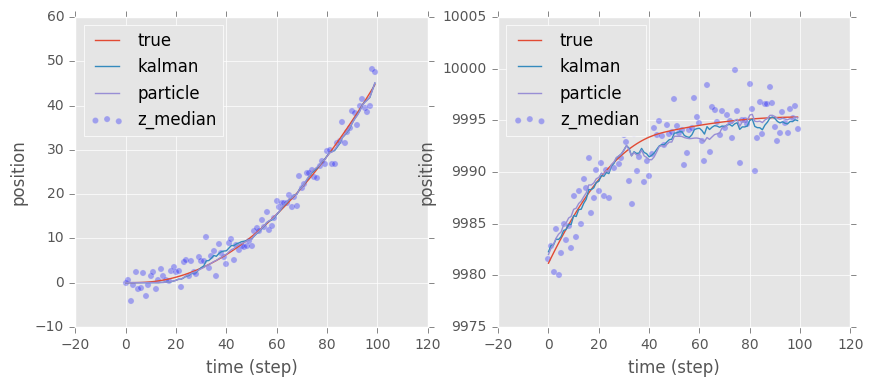

In [5]:
T = 100
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(range(T), x_true[:T, 0], label='true')
plt.plot(range(T), x_kalman[:T, 0], label='kalman')
plt.plot(range(T), x_particle[:T, 0], label='particle')
plt.scatter(range(T), r_naive[:T], label='z_median', alpha=0.3)
plt.legend(loc='best')
plt.xlabel('time (step)')
plt.ylabel('position');

plt.subplot(122)
plt.plot(range(T), x_true[-T:, 0], label='true')
plt.plot(range(T), x_kalman[-T:, 0], label='kalman')
plt.plot(range(T), x_particle[-T:, 0], label='particle')
plt.scatter(range(T), r_naive[-T:], label='z_median', alpha=0.3)
plt.legend(loc='best')
plt.xlabel('time (step)')
plt.ylabel('position');

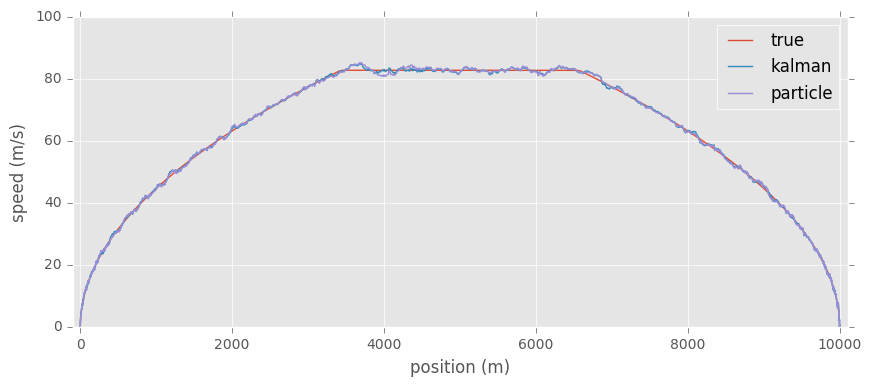

In [6]:
plt.figure(figsize=(10,4))
plt.plot(x_true[:, 0], x_true[:, 1], label='true')
plt.plot(x_kalman[:, 0], x_kalman[:, 1], label='kalman')
plt.plot(x_particle[:, 0], x_particle[:, 1], label='particle')
plt.legend(loc='best')
plt.xlabel('position (m)')
plt.ylabel('speed (m/s)')
plt.ylim([0, 100])
plt.xlim([-100, 10100]);

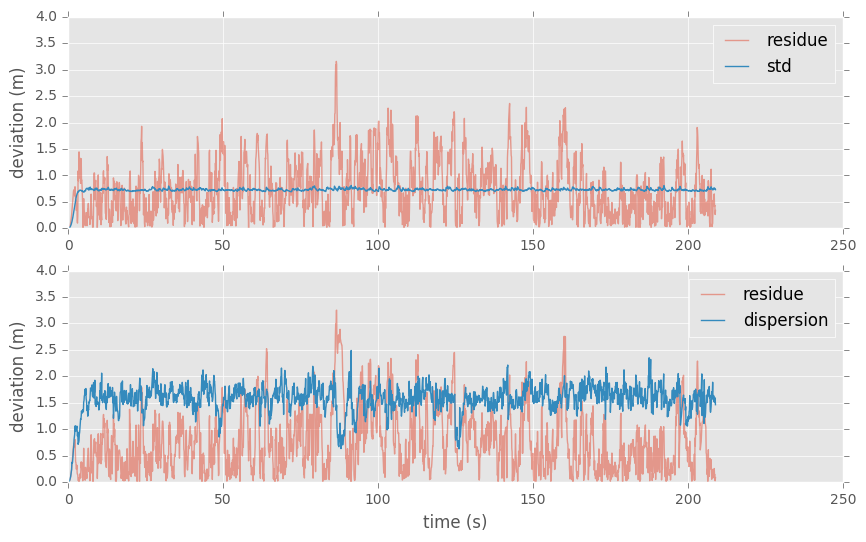

In [7]:
index = np.arange(0, train.t+dt, dt)

plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(index, np.abs(x_kalman[:, 0]-x_true[:, 0]), alpha=0.5, label='residue')
plt.plot(index, np.sqrt(variance_kalman), label='std')
plt.legend(loc='best')
plt.ylim([0, 4])
plt.ylabel('deviation (m)');

plt.subplot(212)
plt.plot(index, np.abs(x_particle[:, 0]-x_true[:, 0]), alpha=0.5, label='residue')
plt.plot(index, dispersion_particle, label='dispersion')
plt.legend(loc='best')
plt.ylim([0, 4])
plt.xlabel('time (s)')
plt.ylabel('deviation (m)');